人名分类器
===
以一个人名为输入，使用模型帮助我们判断它最优可能是来自哪一个国家的人名

# 1.导入必备的工具包

In [2]:
from io import open
import glob
import os
import string
import unicodedata
import random
import time
import math
import torch
import matplotlib.pyplot as plt

# 2.文件数据处理

In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_letters

57

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

In [5]:
s = "Ślusàrski"
a = unicodeToAscii(s)
print(a)

Slusarski


In [6]:
data_path = "data/names/"

def readLines(filename):
    """从文件中读取每一行加载到内存中形成列表"""
    # 打开指定文件并读取所有内容, 使用strip()去除两侧空白符, 然后以'\n'进行切分
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    # 对应每一个lines列表中的名字进行Ascii转换, 使其规范化.最后返回一个名字列表
    return [unicodeToAscii(line) for line in lines]

In [7]:
filename = data_path + "Chinese.txt"
lines = readLines(filename)
print(lines)

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao', 'Cen', 'Chai', 'Chaim', 'Chan', 'Chang', 'Chao', 'Che', 'Chen', 'Cheng', 'Cheung', 'Chew', 'Chieu', 'Chin', 'Chong', 'Chou', 'Chu', 'Cui', 'Dai', 'Deng', 'Ding', 'Dong', 'Dou', 'Duan', 'Eng', 'Fan', 'Fei', 'Feng', 'Foong', 'Fung', 'Gan', 'Gauk', 'Geng', 'Gim', 'Gok', 'Gong', 'Guan', 'Guang', 'Guo', 'Gwock', 'Han', 'Hang', 'Hao', 'Hew', 'Hiu', 'Hong', 'Hor', 'Hsiao', 'Hua', 'Huan', 'Huang', 'Hui', 'Huie', 'Huo', 'Jia', 'Jiang', 'Jin', 'Jing', 'Joe', 'Kang', 'Kau', 'Khoo', 'Khu', 'Kong', 'Koo', 'Kwan', 'Kwei', 'Kwong', 'Lai', 'Lam', 'Lang', 'Lau', 'Law', 'Lew', 'Lian', 'Liao', 'Lim', 'Lin', 'Ling', 'Liu', 'Loh', 'Long', 'Loong', 'Luo', 'Mah', 'Mai', 'Mak', 'Mao', 'Mar', 'Mei', 'Meng', 'Miao', 'Min', 'Ming', 'Moy', 'Mui', 'Nie', 'Niu', 'OuYang', 'OwYang', 'Pan', 'Pang', 'Pei', 'Peng', 'Ping', 'Qian', 'Qin', 'Qiu', 'Quan', 'Que', 'Ran', 'Rao', 'Rong', 'Ruan', 'Sam', 'Seah', 'See ', 'Seow', 'Seto', 'Sha', 'Shan', 'Sh

构建人名类别（所属的语言）列表与人名对应关系字典

In [8]:
# 构建的category_lines形如：{"English":["Lily", "Susan", "Kobe"], "Chinese":["Zhang San", "Xiao Ming"]}
category_lines = {}

# all_categories形如： ["English",...,"Chinese"]
all_categories = []

# 读取指定路径下的txt文件， 使用glob，path中可以使用正则表达式
for filename in glob.glob(data_path + '*.txt'):
    # 获取每个文件的文件名, 就是对应的名字类别
    category = os.path.splitext(os.path.basename(filename))[0]
    # 将其逐一装到all_categories列表中
    all_categories.append(category)
    # 然后读取每个文件的内容，形成名字列表
    lines = readLines(filename)
    # 按照对应的类别，将名字列表写入到category_lines字典中
    category_lines[category] = lines

# 查看类别总数
n_categories = len(all_categories)
print("n_categories:", n_categories)

# 随便查看其中的一些内容
print(category_lines['Italian'][:5])

n_categories: 18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [9]:
# 将字符串(单词粒度)转化为张量表示，如："ab" --->
# tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0.]],

#        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0.]]])
def lineToTensor(line):
    """将人名转化为对应onehot张量表示, 参数line是输入的人名"""
    # 首先初始化一个0张量, 它的形状(len(line), 1, n_letters) 
    # 代表人名中的每个字母用一个1 x n_letters的张量表示.
    tensor = torch.zeros(len(line), 1, n_letters)
    # 遍历这个人名中的每个字符索引和字符
    for li, letter in enumerate(line):
        # 使用字符串方法find找到每个字符在all_letters中的索引
        # 它也是我们生成onehot张量中1的索引位置
        tensor[li][0][all_letters.find(letter)] = 1
    # 返回结果
    return tensor

In [10]:
line = "Bai"
line_tensor = lineToTensor(line)
print("line_tensot:", line_tensor)

line_tensot: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])


In [11]:
# 因为是onehot编码, 输入张量最后一维的尺寸就是n_letters
input_size = n_letters
# 定义隐层的最后一维尺寸大小
n_hidden = 128
# 输出尺寸为语言类别总数n_categories
output_size = n_categories
# num_layer使用默认值, num_layers = 1
# 假如我们以一个字母B作为RNN的首次输入, 它通过lineToTensor转为张量
# 因为我们的lineToTensor输出是三维张量, 而RNN类需要的二维张量
# 因此需要使用squeeze(0)降低一个维度
input = lineToTensor('B').squeeze(0)
# 初始化一个三维的隐层0张量, 也是初始的细胞状态张量
hidden = c = torch.zeros(1, 1, n_hidden)

In [12]:
def categoryFromOutput(output):
    """从输出结果中获得指定类别, 参数为输出张量output"""
    # 从输出张量中返回最大的值和索引对象, 我们这里主要需要这个索引
    top_n, top_i = output.topk(1)
    # top_i对象中取出索引的值
    category_i = top_i[0].item()
    # 根据索引值获得对应语言类别, 返回语言类别和索引值
    return all_categories[category_i], category_i

In [13]:
x = torch.arange(1., 6.)
x

tensor([1., 2., 3., 4., 5.])

In [15]:
def randomTrainingExample():
    """该函数用于随机产生训练数据"""
    # 首先使用random的choice方法从all_categories随机选择一个类别
    category = random.choice(all_categories)
    # 然后在通过category_lines字典取category类别对应的名字列表
    # 之后再从列表中随机取一个名字
    line = random.choice(category_lines[category])
    # 接着将这个类别在所有类别列表中的索引封装成tensor, 得到类别张量category_tensor
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    # 最后, 将随机取到的名字通过函数lineToTensor转化为onehot张量表示
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [16]:
# 我们随机取出十个进行结果查看
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, '/ category_tensor =', category_tensor)

category = Czech / line = Cermak / category_tensor = tensor([0])
category = Chinese / line = Yan / category_tensor = tensor([4])
category = Arabic / line = Hanania / category_tensor = tensor([2])
category = Spanish / line = Porra / category_tensor = tensor([10])
category = Scottish / line = Kelly / category_tensor = tensor([14])
category = Scottish / line = Stewart / category_tensor = tensor([14])
category = Scottish / line = Graham / category_tensor = tensor([14])
category = Dutch / line = Haanraats / category_tensor = tensor([15])
category = Italian / line = Negri / category_tensor = tensor([12])
category = French / line = Rome / category_tensor = tensor([7])


# 3. 构建辅助函数

In [17]:
def timeSince(since):
    "获得每次打印的训练耗时, since是训练开始时间"
    # 获得当前时间
    now = time.time()
    # 获得时间差，就是训练耗时
    s = now - since
    # 将秒转化为分钟, 并取整
    m = math.floor(s / 60)
    # 计算剩下不够凑成1分钟的秒数
    s -= m * 60
    # 返回指定格式的耗时
    return '%dm %ds' % (m, s)

In [18]:
since = time.time() - 10*60
period = timeSince(since)
print(period)

10m 0s


In [19]:
# 设置训练迭代次数
n_iters = 1000
# 设置结果的打印间隔
print_every = 50
# 设置绘制损失曲线上的制图间隔
plot_every = 10

def train(train_type_fn):
    """训练过程的日志打印函数, 参数train_type_fn代表选择哪种模型训练函数, 如trainRNN"""
    # 每个制图间隔损失保存列表
    all_losses = []
    # 获得训练开始时间戳
    start = time.time()
    # 设置初始间隔损失为0
    current_loss = 0
    # 从1开始进行训练迭代, 共n_iters次 
    for iter in range(1, n_iters + 1):
        # 通过randomTrainingExample函数随机获取一组训练数据和对应的类别
        category, line, category_tensor, line_tensor = randomTrainingExample()
        # 将训练数据和对应类别的张量表示传入到train函数中
        output, loss = train_type_fn(category_tensor, line_tensor)      
        # 计算制图间隔中的总损失
        current_loss += loss   
        # 如果迭代数能够整除打印间隔
        if iter % print_every == 0:
            # 取该迭代步上的output通过categoryFromOutput函数获得对应的类别和类别索引
            guess, guess_i = categoryFromOutput(output)
            # 然后和真实的类别category做比较, 如果相同则打对号, 否则打叉号.
            correct = '✓' if guess == category else '✗ (%s)' % category
            # 打印迭代步, 迭代步百分比, 当前训练耗时, 损失, 该步预测的名字, 以及是否正确                                
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # 如果迭代数能够整除制图间隔
        if iter % plot_every == 0:
            # 将保存该间隔中的平均损失到all_losses列表中
            all_losses.append(current_loss / plot_every)
            # 间隔损失重置为0
            current_loss = 0
    # 返回对应的总损失列表和训练耗时
    return all_losses, int(time.time() - start)

# 4. 使用RNN解决问题

In [20]:
# 使用nn.RNN构建完成传统RNN使用类
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """初始化函数中有4个参数, 分别代表RNN输入最后一维尺寸, RNN的隐层最后一维尺寸, RNN层数"""
        super(RNN, self).__init__()       
        # 将hidden_size与num_layers传入其中
        self.hidden_size = hidden_size
        self.num_layers = num_layers  

        # 实例化预定义的nn.RNN, 它的三个参数分别是input_size, hidden_size, num_layers
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers)
        # 实例化nn.Linear, 这个线性层用于将nn.RNN的输出维度转化为指定的输出维度
        self.linear = torch.nn.Linear(hidden_size, output_size)
        # 实例化nn中预定的Softmax层, 用于从输出层获得类别结果
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        """完成传统RNN中的主要逻辑, 输入参数input代表输入张量, 它的形状是1 x n_letters
           hidden代表RNN的隐层张量, 它的形状是self.num_layers x 1 x self.hidden_size"""
        # 因为预定义的nn.RNN要求输入维度一定是三维张量, 因此在这里使用unsqueeze(0)扩展一个维度
        input = input.unsqueeze(0)
        # 将input和hidden输入到传统RNN的实例化对象中，如果num_layers=1, rr恒等于hn
        rr, hn = self.rnn(input, hidden)
        # 将从RNN中获得的结果通过线性变换和softmax返回，同时返回hn作为后续RNN的输入
        return self.softmax(self.linear(rr)), hn


    def initHidden(self):
        """初始化隐层张量"""
        # 初始化一个（self.num_layers, 1, self.hidden_size）形状的0张量     
        return torch.zeros(self.num_layers, 1, self.hidden_size)  

In [21]:
x = torch.tensor([1, 2, 3, 4])
print(torch.unsqueeze(x, 0))
print(torch.unsqueeze(x, 1))

tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])


In [22]:
rnn = RNN(n_letters, n_hidden, n_categories)
rnn_output, next_hidden = rnn(input, hidden)
print("rnn:", rnn_output)

rnn: tensor([[[-2.8547, -2.8680, -2.8657, -3.0458, -2.8060, -2.8230, -2.8990,
          -2.8622, -2.9806, -2.8730, -2.8865, -3.0292, -2.9244, -2.8250,
          -2.8356, -2.9481, -2.8011, -2.9427]]], grad_fn=<LogSoftmaxBackward>)


In [23]:
# 定义损失函数为nn.NLLLoss，因为RNN的最后一层是nn.LogSoftmax, 两者的内部计算逻辑正好能够吻合.  
criterion = torch.nn.NLLLoss()

# 设置学习率为0.005
learning_rate = 0.005 

def trainRNN(category_tensor, line_tensor):
    """定义训练函数, 它的两个参数是category_tensor类别的张量表示, 相当于训练数据的标签,
       line_tensor名字的张量表示, 相当于对应训练数据"""

    # 在函数中, 首先通过实例化对象rnn初始化隐层张量
    hidden = rnn.initHidden()

    # 然后将模型结构中的梯度归0
    rnn.zero_grad()

    # 下面开始进行训练, 将训练数据line_tensor的每个字符逐个传入rnn之中, 得到最终结果
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # 因为我们的rnn对象由nn.RNN实例化得到, 最终输出形状是三维张量, 为了满足于category_tensor
    # 进行对比计算损失, 需要减少第一个维度, 这里使用squeeze()方法
    loss = criterion(output.squeeze(0), category_tensor)

    # 损失进行反向传播
    loss.backward()
    # 更新模型中所有的参数
    for p in rnn.parameters():
        # 将参数的张量表示与参数的梯度乘以学习率的结果相加以此来更新参数
        p.data.add_(-learning_rate, p.grad.data)
    # 返回结果和损失的值
    return output, loss.item()

In [25]:
# 调用train函数, 分别进行RNN, LSTM, GRU模型的训练
# 并返回各自的全部损失, 以及训练耗时用于制图
all_losses1, period1 = train(trainRNN)

50 5% (0m 0s) 2.8670 Prescott / Portuguese ✗ (English)
100 10% (0m 0s) 2.6976 Yakushev / Russian ✓
150 15% (0m 0s) 2.8175 Wan / French ✗ (Chinese)
200 20% (0m 0s) 2.8990 Berger / French ✗ (German)
250 25% (0m 0s) 2.8109 Luc / Czech ✗ (Vietnamese)
300 30% (0m 0s) 2.9844 O'Neal / Scottish ✗ (Irish)
350 35% (0m 0s) 2.7810 Zhaivoronok / Korean ✗ (Russian)
400 40% (0m 0s) 2.9252 Alves / Greek ✗ (Spanish)
450 45% (0m 1s) 2.8990 Almeida / Arabic ✗ (Portuguese)
500 50% (0m 1s) 2.9730 Iwasa / French ✗ (Japanese)
550 55% (0m 1s) 2.7811 Araullo / French ✗ (Portuguese)
600 60% (0m 1s) 2.7315 Mitchell / French ✗ (Scottish)
650 65% (0m 1s) 2.5866 Xydis / Greek ✓
700 70% (0m 1s) 2.7149 Poulin / French ✓
750 75% (0m 1s) 2.7649 La / Vietnamese ✓
800 80% (0m 1s) 2.9598 Daal / Scottish ✗ (Dutch)
850 85% (0m 1s) 2.7974 Dieter / French ✗ (German)
900 90% (0m 2s) 2.7517 Ma / Vietnamese ✓
950 95% (0m 2s) 2.7431 Giang / Arabic ✗ (Vietnamese)
1000 100% (0m 2s) 2.8694 Peter / French ✗ (Dutch)


# 5. 使用LSTM模型解决问题

In [26]:
# 使用nn.LSTM构建完成LSTM使用类

class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """初始化函数的参数与传统RNN相同"""
        super(LSTM, self).__init__()
        # 将hidden_size与num_layers传入其中
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 实例化预定义的nn.LSTM
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers)
        # 实例化nn.Linear, 这个线性层用于将nn.RNN的输出维度转化为指定的输出维度
        self.linear = torch.nn.Linear(hidden_size, output_size)
        # 实例化nn中预定的Softmax层, 用于从输出层获得类别结果
        self.softmax = torch.nn.LogSoftmax(dim=-1)


    def forward(self, input, hidden, c):
        """在主要逻辑函数中多出一个参数c, 也就是LSTM中的细胞状态张量"""
        # 使用unsqueeze(0)扩展一个维度
        input = input.unsqueeze(0)
        # 将input, hidden以及初始化的c传入lstm中
        rr, (hn, c) = self.lstm(input, (hidden, c))
        # 最后返回处理后的rr, hn, c
        return self.softmax(self.linear(rr)), hn, c

    def initHiddenAndC(self):  
        """初始化函数不仅初始化hidden还要初始化细胞状态c, 它们形状相同"""
        c = hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        return hidden, c

In [27]:
lstm = LSTM(n_letters, n_hidden, n_categories)
lstm_output, next_hidden, c = lstm(input, hidden, c)
print("lstm:", lstm_output)

lstm: tensor([[[-2.8460, -2.8630, -2.7889, -2.9906, -2.8660, -2.8571, -2.8756,
          -2.8414, -2.8086, -2.8706, -2.9799, -2.9097, -2.9780, -2.9793,
          -2.8561, -2.9242, -2.8348, -2.9939]]], grad_fn=<LogSoftmaxBackward>)


In [28]:
# 与传统RNN相比多出细胞状态c

def trainLSTM(category_tensor, line_tensor):
    hidden, c = lstm.initHiddenAndC()
    lstm.zero_grad()
    for i in range(line_tensor.size()[0]):
        # 返回output, hidden以及细胞状态c
        output, hidden, c = lstm(line_tensor[i], hidden, c)
    loss = criterion(output.squeeze(0), category_tensor)
    loss.backward()

    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [29]:
all_losses2, period2 = train(trainLSTM)

50 5% (0m 0s) 2.8395 Ryom / Arabic ✗ (Korean)
100 10% (0m 0s) 2.8084 O'Connor / Arabic ✗ (Irish)
150 15% (0m 0s) 2.8534 Cunningham / Arabic ✗ (Scottish)
200 20% (0m 0s) 2.8410 Shon / Irish ✗ (Korean)
250 25% (0m 0s) 2.8756 Qing / Irish ✗ (Chinese)
300 30% (0m 1s) 2.7843 Domhnall / Arabic ✗ (Irish)
350 35% (0m 1s) 3.0045 Olguin / Irish ✗ (Spanish)
400 40% (0m 1s) 2.8528 Cheng / Arabic ✗ (Chinese)
450 45% (0m 1s) 2.8647 Sai / Irish ✗ (Vietnamese)
500 50% (0m 1s) 2.8515 Taylor / Arabic ✗ (Scottish)
550 55% (0m 1s) 2.9041 Darchinyants / Arabic ✗ (Russian)
600 60% (0m 2s) 2.9387 Glatter / Arabic ✗ (Czech)
650 65% (0m 2s) 2.8325 Gil / Arabic ✗ (Korean)
700 70% (0m 2s) 2.9002 Singleton / Arabic ✗ (English)
750 75% (0m 2s) 2.8902 Leon / Arabic ✗ (French)
800 80% (0m 2s) 2.8950 Severin / Arabic ✗ (French)
850 85% (0m 3s) 2.8631 Thach / Arabic ✗ (Vietnamese)
900 90% (0m 3s) 2.8988 Kitano / Arabic ✗ (Japanese)
950 95% (0m 3s) 2.8686 King / Arabic ✗ (English)
1000 100% (0m 3s) 2.8880 Katsumata / A

# 6. 使用GRU模型构建问题

In [30]:
# 使用nn.GRU构建完成传统RNN使用类
# GRU与传统RNN的外部形式相同, 都是只传递隐层张量, 因此只需要更改预定义层的名字
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 实例化预定义的nn.GRU, 它的三个参数分别是input_size, hidden_size, num_layers
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers)
        self.linear = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        rr, hn = self.gru(input, hidden)
        return self.softmax(self.linear(rr)), hn

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)

In [31]:
gru = GRU(n_letters, n_hidden, n_categories)
gru_output, next_hidden = gru(input, hidden)
print("gru:", gru_output)

gru: tensor([[[-2.8084, -2.8013, -2.9020, -2.8224, -2.9233, -2.9539, -2.9528,
          -2.8659, -2.8182, -2.9428, -2.9374, -2.8925, -2.9843, -2.9554,
          -2.8804, -2.8853, -2.8480, -2.8796]]], grad_fn=<LogSoftmaxBackward>)


In [32]:
def trainGRU(category_tensor, line_tensor):
    hidden = gru.initHidden()
    gru.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden= gru(line_tensor[i], hidden)
    loss = criterion(output.squeeze(0), category_tensor)
    loss.backward()

    for p in gru.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [33]:
all_losses3, period3 = train(trainGRU)

50 5% (0m 0s) 2.8493 Gravari / Irish ✗ (Greek)
100 10% (0m 0s) 2.8833 Dickson / German ✗ (Scottish)
150 15% (0m 0s) 2.8546 Ivor / German ✗ (Irish)
200 20% (0m 0s) 2.8861 Dertilis / German ✗ (Greek)
250 25% (0m 0s) 2.9171 Grec / German ✗ (Spanish)
300 30% (0m 1s) 2.9920 Banh / German ✗ (Vietnamese)
350 35% (0m 1s) 2.8758 Shaw / German ✗ (Scottish)
400 40% (0m 1s) 2.6842 Teufel / German ✓
450 45% (0m 1s) 2.8237 Poingdestre / German ✗ (French)
500 50% (0m 1s) 2.8405 Watson / German ✗ (Scottish)
550 55% (0m 2s) 2.9001 Yuan / German ✗ (Chinese)
600 60% (0m 2s) 2.8303 Thibault / German ✗ (French)
650 65% (0m 2s) 2.8162 Bellamy / German ✗ (French)
700 70% (0m 2s) 2.9167 Mayer / German ✗ (Czech)
750 75% (0m 2s) 2.9027 Alagona / German ✗ (Italian)
800 80% (0m 2s) 2.8875 Kong / German ✗ (Chinese)
850 85% (0m 3s) 2.7550 Perrot / French ✓
900 90% (0m 3s) 2.9420 Vigo / French ✗ (Italian)
950 95% (0m 3s) 2.8008 Kawachi / French ✗ (Japanese)
1000 100% (0m 3s) 2.7385 Lange / German ✓


# 7. 绘制损失图与时间对比图

<BarContainer object of 3 artists>

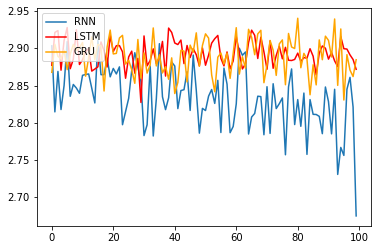

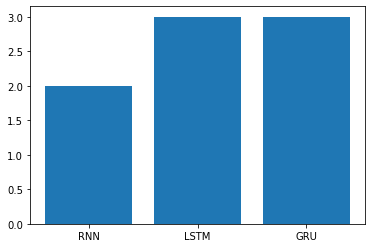

In [34]:
# 绘制损失对比曲线, 训练耗时对比柱张图
# 创建画布0
plt.figure(0)
# 绘制损失对比曲线
plt.plot(all_losses1, label="RNN")
plt.plot(all_losses2, color="red", label="LSTM")
plt.plot(all_losses3, color="orange", label="GRU") 
plt.legend(loc='upper left') 

# 创建画布1
plt.figure(1)
x_data=["RNN", "LSTM", "GRU"] 
y_data = [period1, period2, period3]
# 绘制训练耗时对比柱状图
plt.bar(range(len(x_data)), y_data, tick_label=x_data)

# 8. 构建评估函数并进行预测

In [35]:
def evaluateRNN(line_tensor):
    """评估函数, 和训练函数逻辑相同, 参数是line_tensor代表名字的张量表示"""
    # 初始化隐层张量
    hidden = rnn.initHidden()
    # 将评估数据line_tensor的每个字符逐个传入rnn之中
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    # 获得输出结果
    return output.squeeze(0)

In [36]:
def evaluateLSTM(line_tensor):
    # 初始化隐层张量和细胞状态张量
    hidden, c = lstm.initHiddenAndC()
    # 将评估数据line_tensor的每个字符逐个传入lstm之中
    for i in range(line_tensor.size()[0]):
        output, hidden, c = lstm(line_tensor[i], hidden, c)
    return output.squeeze(0)

In [37]:
def evaluateGRU(line_tensor):
    hidden = gru.initHidden()
    # 将评估数据line_tensor的每个字符逐个传入gru之中
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    return output.squeeze(0)

In [38]:
line = "Bai"
line_tensor = lineToTensor(line)
rnn_output = evaluateRNN(line_tensor)
lstm_output = evaluateLSTM(line_tensor)
gru_output = evaluateGRU(line_tensor)
print("rnn_output:", rnn_output)
print("gru_output:", lstm_output)
print("gru_output:", gru_output)

rnn_output: tensor([[-3.0423, -2.9684, -2.7266, -2.9670, -2.7551, -2.5885, -3.0765, -2.9335,
         -2.9198, -3.0803, -2.7874, -2.9898, -2.6691, -2.9373, -2.8322, -3.0915,
         -2.9129, -2.9336]], grad_fn=<SqueezeBackward1>)
gru_output: tensor([[-2.9638, -2.8393, -2.7941, -2.8741, -2.9085, -2.8788, -2.8632, -2.9411,
         -2.8358, -2.8844, -2.9754, -2.8993, -2.9415, -2.9550, -2.8575, -2.8920,
         -2.8354, -2.9090]], grad_fn=<SqueezeBackward1>)
gru_output: tensor([[-2.8990, -2.7631, -2.9123, -2.7882, -2.8574, -2.9747, -2.9629, -2.7745,
         -2.9046, -2.9752, -2.8848, -2.9126, -2.9721, -2.9463, -2.8860, -2.9770,
         -2.8803, -2.7999]], grad_fn=<SqueezeBackward1>)


In [39]:
def predict(input_line, evaluate, n_predictions=3):
    """预测函数, 输入参数input_line代表输入的名字, 
       n_predictions代表需要取最有可能的top个"""
    # 首先打印输入
    print('\n> %s' % input_line)

    # 以下操作的相关张量不进行求梯度
    with torch.no_grad():
        # 使输入的名字转换为张量表示, 并使用evaluate函数获得预测输出
        output = evaluate(lineToTensor(input_line))

        # 从预测的输出中取前3个最大的值及其索引
        topv, topi = output.topk(n_predictions, 1, True)
        # 创建盛装结果的列表
        predictions = []
        # 遍历n_predictions
        for i in range(n_predictions):
            # 从topv中取出的output值
            value = topv[0][i].item()
            # 取出索引并找到对应的类别
            category_index = topi[0][i].item()
            # 打印ouput的值, 和对应的类别
            print('(%.2f) %s' % (value, all_categories[category_index]))
            # 将结果装进predictions中
            predictions.append([value, all_categories[category_index]])

In [44]:
for evaluate_fn in [evaluateRNN, evaluateLSTM, evaluateGRU]: 
    print("-"*18)
    predict('Dovesky', evaluate_fn)
    predict('Jackson', evaluate_fn)
    predict('Satoshi', evaluate_fn)
    predict("Zhang", evaluate_fn)

------------------

> Dovesky
(-2.68) Irish
(-2.71) Scottish
(-2.72) Arabic

> Jackson
(-2.66) Irish
(-2.71) Scottish
(-2.74) Greek

> Satoshi
(-2.62) Italian
(-2.69) Scottish
(-2.76) Arabic

> Zhang
(-2.71) Vietnamese
(-2.72) Arabic
(-2.78) Scottish
------------------

> Dovesky
(-2.78) Arabic
(-2.84) Korean
(-2.85) German

> Jackson
(-2.81) Arabic
(-2.84) Korean
(-2.84) Irish

> Satoshi
(-2.79) Arabic
(-2.84) Irish
(-2.84) German

> Zhang
(-2.79) Arabic
(-2.83) Irish
(-2.85) Korean
------------------

> Dovesky
(-2.74) German
(-2.76) French
(-2.81) Chinese

> Jackson
(-2.73) German
(-2.77) French
(-2.82) Polish

> Satoshi
(-2.76) German
(-2.77) French
(-2.79) Japanese

> Zhang
(-2.74) German
(-2.77) French
(-2.81) Polish
